In [15]:
# Импорт Pandas для работы с DataFrame
import pandas as pd

In [16]:
# Чтение CSV-файла в DataFrame
df = pd.read_csv("Lab4.csv")

# Вывод первых 5 строк для проверки
print(df.head())

   client_id          DIR   Age  NumLoans  NumRealEstateLoans  NumDependents  \
0          0     0.496289  49.1        13                   0            0.0   
1          1     0.433567  48.0         9                   2            2.0   
2          2  2206.731199  55.5        21                   1            NaN   
3          3   886.132793  55.3         3                   0            0.0   
4          4     0.000000  52.3         1                   0            0.0   

   Num30-59Delinquencies  Num60-89Delinquencies       Income  \
0                      2                      0  5298.360639   
1                      1                      0  6008.056256   
2                      1                      0          NaN   
3                      0                      0          NaN   
4                      0                      0  2504.613105   

   BalanceToCreditLimit  Delinquent90  
0              0.387028             0  
1              0.234679             0  
2             

In [18]:
# Вывод количества пропусков по всем столбцам
print("Пропущенные значения по всем столбцам:")
print(df.isnull().sum())

Пропущенные значения по всем столбцам:
client_id                    0
DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64


In [19]:
# Найти полностью одинаковые строки
print("Полные дубликаты строк:", df.duplicated().any())

Полные дубликаты строк: False


In [20]:
# Удаление ненужного столбца
df = df.drop(columns=['client_id'])

# Проверим результат
print(df.head())

           DIR   Age  NumLoans  NumRealEstateLoans  NumDependents  \
0     0.496289  49.1        13                   0            0.0   
1     0.433567  48.0         9                   2            2.0   
2  2206.731199  55.5        21                   1            NaN   
3   886.132793  55.3         3                   0            0.0   
4     0.000000  52.3         1                   0            0.0   

   Num30-59Delinquencies  Num60-89Delinquencies       Income  \
0                      2                      0  5298.360639   
1                      1                      0  6008.056256   
2                      1                      0          NaN   
3                      0                      0          NaN   
4                      0                      0  2504.613105   

   BalanceToCreditLimit  Delinquent90  
0              0.387028             0  
1              0.234679             0  
2              0.348227             0  
3              0.971930             0  


In [21]:
# заполнить 0 (предположение, что нет иждивенцев)
df['NumDependents'] = df['NumDependents'].fillna(0)

# заполнить медианой (устойчивость к выбросам)
median_income = df['Income'].median()
df['Income'] = df['Income'].fillna(median_income)


# Вывод количества пропусков по всем столбцам
print("Пропущенные значения по всем столбцам:")
print(df.isnull().sum())

Пропущенные значения по всем столбцам:
DIR                      0
Age                      0
NumLoans                 0
NumRealEstateLoans       0
NumDependents            0
Num30-59Delinquencies    0
Num60-89Delinquencies    0
Income                   0
BalanceToCreditLimit     0
Delinquent90             0
dtype: int64


In [22]:
# Импортируем функцию для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

y = df['Delinquent90'].copy()
x = df.drop(columns=['Delinquent90']).copy()

# Разделяем данные для обучения и теста

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [23]:
# Импортируем класс для нормализации данных
from sklearn.preprocessing import StandardScaler

# Создаём объект StandardScaler
scaler = StandardScaler()

# Обучаем скалер на обучающих данных И преобразуем их
x_train_scaled = scaler.fit_transform(x_train)

# Преобразуем тестовые данные ТОЛЬКО с помощью уже обученного скалера
x_test_scaled = scaler.transform(x_test)


In [25]:
from sklearn.tree import DecisionTreeClassifier

# Создаем модель
dt = DecisionTreeClassifier(
    max_depth=3,
    random_state=42,
    criterion='gini'
)

# Обучаем на обучающих данных
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

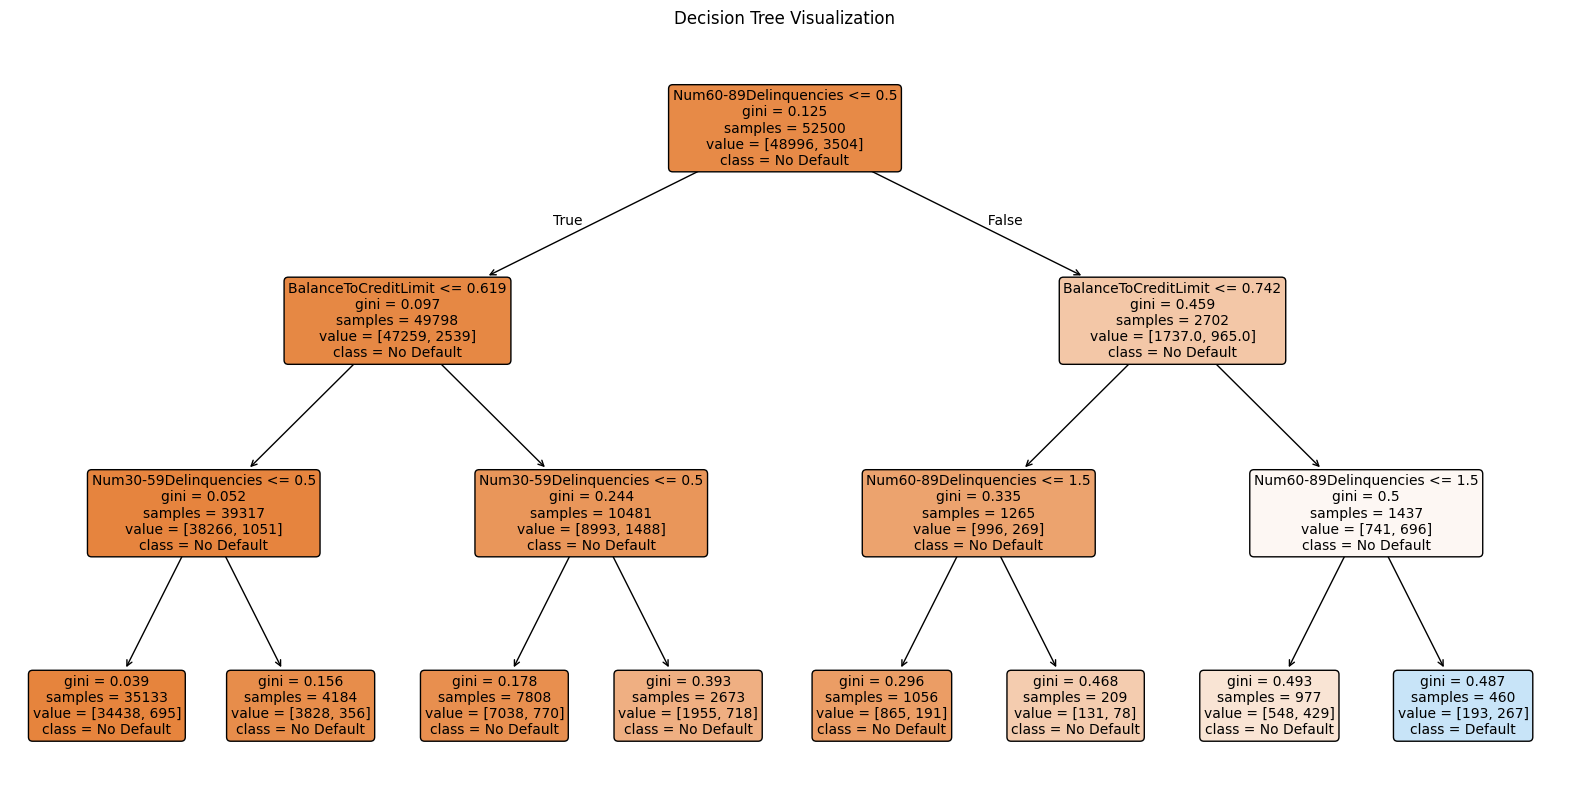

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=x.columns,  # Имена признаков
    class_names=['No Default', 'Default'],  # Имена классов (0 и 1)
    filled=True,        # Цвета узлов по классу
    rounded=True,       # Скруглённые узлы
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"{'depth':<5} {'acc':<10} {'prec':<10} {'recall':<10} {'f1':<10} {'auc':<10}")
print("-" * 60)

best_recall = 0
best_depth = 1

for depth in range(1, 12):  # от 1 до 11
    # Обучаем дерево
    dt = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42,
        class_weight='balanced'  # важно для несбалансированных данных
    )
    dt.fit(x_train, y_train)

    # Предсказания
    y_pred = dt.predict(x_test)          # предсказанные классы (0 или 1)
    y_pred_proba = dt.predict_proba(x_test)  # вероятности для каждого класса

    # Метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # для вероятностей класса 1

    # Вывод строки
    print(f"{depth:<5} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f} {auc:<10.4f}")

    # Отслеживаем лучшую глубину по F1 на тесте
    if rec > best_recall:
        best_recall = rec
        best_depth = depth

print("-" * 60)
print(f"Оптимальная глубина по recall: {best_depth} (recall = {best_recall:.4f})")

depth acc        prec       recall     f1         auc       
------------------------------------------------------------
1     0.7156     0.1560     0.7349     0.2574     0.7245    
2     0.6604     0.1474     0.8496     0.2512     0.7897    
3     0.6534     0.1464     0.8628     0.2503     0.8085    
4     0.8085     0.2123     0.6846     0.3241     0.8274    
5     0.7149     0.1681     0.8231     0.2792     0.8320    
6     0.7832     0.1982     0.7336     0.3121     0.8266    
7     0.7678     0.1877     0.7402     0.2995     0.8149    
8     0.7831     0.1952     0.7157     0.3068     0.7991    
9     0.7651     0.1823     0.7184     0.2909     0.7791    
10    0.7797     0.1852     0.6720     0.2903     0.7570    
11    0.7770     0.1807     0.6581     0.2836     0.7326    
------------------------------------------------------------
Оптимальная глубина по recall: 3 (recall = 0.8628)


Целевая переменная: Delinquent90 — был ли дефолт (просрочка >90 дней).
Это задача обнаружения редкого, но критически важного события (дефолт).
В банковской практике:
Ложноотрицательные (FN) — клиент дефолтнул, но модель сказала «нет» → очень дорого (убытки).
Ложноположительные (FP) — клиент не дефолтнул, но модель сказала «да» → менее критично (можно отказать в кредите, но убыток меньше).

Следовательно, важно максимизировать recall (Доля найденных дефолтов от всех реальных дефолтов)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Расширенная сетка параметров
param_grid = {
    'max_depth': list(range(1, 12)),          # от 1 до 11
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'class_weight': [None, 'balanced'],       # даём выбор
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1  # чтобы видеть прогресс
)

grid_search.fit(x_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший Recall (CV):", grid_search.best_score_)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier


# Базовая модель — дерево решений
base_estimator = DecisionTreeClassifier(random_state=42)

# Ансамбль — бэггинг
bagging = BaggingClassifier(estimator=base_estimator, random_state=42)

# Правильная сетка параметров для DecisionTreeClassifier
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.7, 1.0],
    'estimator__max_depth': [3, 5, 7, None],           # глубина дерева
    'estimator__min_samples_split': [2, 5, 10],        # мин. объектов для разделения
    'estimator__criterion': ['gini', 'entropy'],       # критерий качества
    'estimator__min_samples_leaf': [1, 2, 4]           # мин. объектов в листе
}

# Поиск по сетке
grid_search = GridSearchCV(
    bagging,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

# Вывод результатов
print("\nЛучшие параметры:")
print(grid_search.best_params_)
print(f"Лучший ROC-AUC на CV: {grid_search.best_score_:.4f}")

# Оценка на тесте
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Тестовый ROC-AUC: {test_roc_auc:.4f}")

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
